In [ ]:
import numpy as np
import pandas as pd
import os
import random
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input, EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
import itertools
from sklearn.metrics import classification_report, confusion_matrix
import zipfile
from google.colab import drive

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/GarbageDatasets/garbage_classification_del.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()
base_path = "../tmp/garbage_classification_del/"
print('Done')


Done


In [ ]:
categories = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes','e-waste', 'green-glass','light-bulbs', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)
    return df

In [ ]:
filenames_list = []
categories_list = []

for category in categories:
    filenames = os.listdir(base_path + category)
    
    filenames_list += filenames
    categories_list += [category] * len(filenames)

df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
})

df = add_class_name_prefix(df, 'filename')

df = df.sample(frac=1).reset_index(drop=True)

df.head(20)

,filename,category
0,biological/biological713.jpg,biological
1,battery/battery1728.jpg,battery
2,e-waste/e-waste202.jpg,e-waste
3,biological/biological76.jpg,biological
4,battery/battery1367.jpg,battery
5,green-glass/green-glass597.jpg,green-glass
6,metal/metal485.jpg,metal
7,clothes/clothes5206.jpg,clothes
8,biological/biological1021.jpg,biological
9,biological/biological1196.jpg,biological


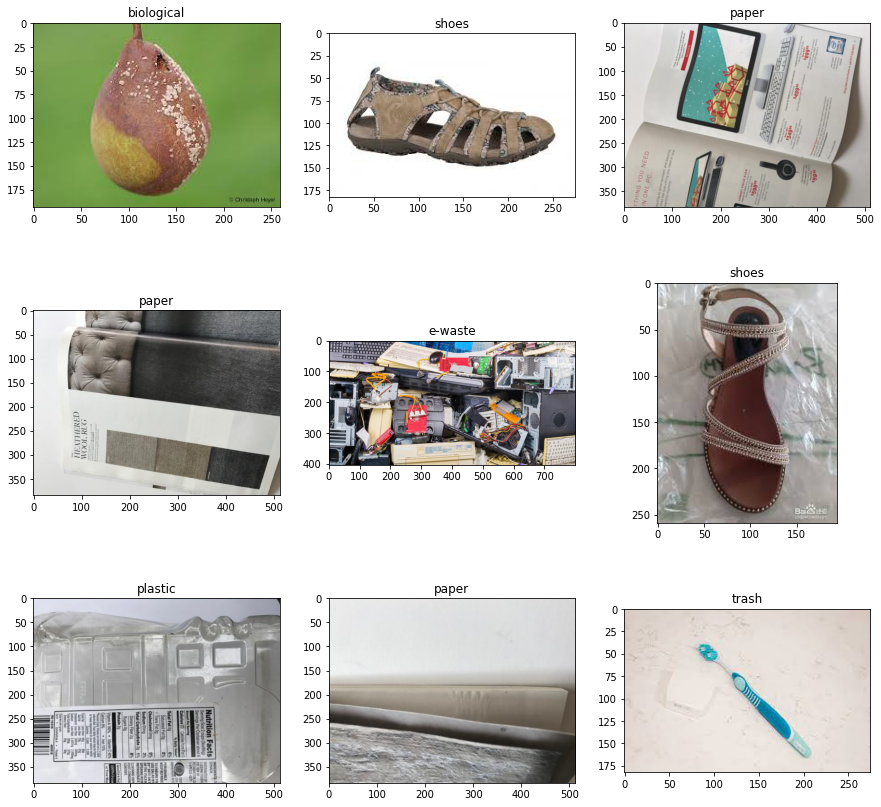

In [ ]:
plt.figure(figsize=(15,15))
for i in range(9):
    random_row = random.randint(0, len(df)-1)
    sample = df.iloc[random_row]
    random_image = image.load_img(base_path + sample['filename'])
    plt.subplot(330 + 1 + i)
    plt.title(sample['category'])
    plt.imshow(random_image)
plt.show()

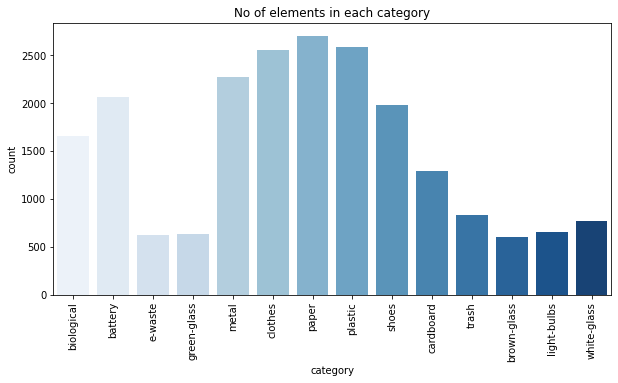

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(x="category", data=df, palette='Blues')
plt.xticks(rotation=90)
plt.title('No of elements in each category')
plt.show()

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
  

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.5, random_state=42)
val_df, test_df = train_test_split(val_df, test_size=0.2, random_state=42)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

len(train_df), len(val_df), len(test_df)

(10615, 8492, 2124)

In [ ]:
train_df.head()

,filename,category
0,battery/battery262.jpg,battery
1,shoes/shoes9.jpg,shoes
2,clothes/clothes4041.jpg,clothes
3,clothes/clothes483.jpg,clothes
4,battery/battery74.jpg,battery


In [ ]:
#CNN

im_shape = (224, 224)
batch_size = 64
seed = 42
train_data_gen = ImageDataGenerator(rescale=1./255)
val_data_gen = ImageDataGenerator(rescale=1./255)
test_data_gen = ImageDataGenerator(rescale=1./255)

print("train")
train_generator = train_data_gen.flow_from_dataframe(
    dataframe=train_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=im_shape,
    class_mode='sparse',
    batch_size=batch_size,
    seed=seed)

print("val")
val_generator = val_data_gen.flow_from_dataframe(
    dataframe=val_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=im_shape,
    class_mode='sparse',
    batch_size=batch_size,
    seed=seed)

print('test')
test_generator = test_data_gen.flow_from_dataframe(
    dataframe=test_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=im_shape,
    color_mode="rgb",
    class_mode="sparse",
    batch_size=1,
    shuffle=False,
    seed=seed)

train
Found 10615 validated image filenames belonging to 14 classes.
val
Found 8492 validated image filenames belonging to 14 classes.
test
Found 2124 validated image filenames belonging to 14 classes.


In [ ]:
nb_train_samples = train_generator.samples
nb_validation_samples = val_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)

Classes: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'e-waste', 'green-glass', 'light-bulbs', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


In [ ]:
input_shape = (224,224,3)
base_model = tf.keras.applications.VGG19( include_top=False, weights = "imagenet", input_shape=input_shape)

# layers trainable pentru fine tunning
base_model.trainable = True
# review model
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# tuning_layer_name = 'conv5_block1_preact_bn'
# tuning_layer = base_model.get
# tuning_index = base_model.layers.index(tuning_layer)

# ighetare layere inainte de tunning
for layer in base_model.layers[:18]:
    layer.trainable =  False

for i, layer in enumerate(base_model.layers):
    print(i, layer.name, layer.trainable)

0 input_2 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_conv4 False
11 block3_pool False
12 block4_conv1 False
13 block4_conv2 False
14 block4_conv3 False
15 block4_conv4 False
16 block4_pool False
17 block5_conv1 False
18 block5_conv2 True
19 block5_conv3 True
20 block5_conv4 True
21 block5_pool True


In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1), 
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)
], name='data_augmentation')

In [ ]:
model = tf.keras.Sequential([
    #data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(14, activation='softmax')
])

learning_rate = 0.001
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
    metrics=['accuracy']
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 14)                7182      
                                                                 
Total params: 20,294,222
Trainable params: 7,349,262
Non-trainable params: 12,944,960
__________________________________

In [ ]:
%%time
epochs = 20

#Callback to save the best model
callbacks_list = [
    ModelCheckpoint(filepath='/tmp/model.h5',monitor='val_loss', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5,verbose=1)
]

#Training
history = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=val_generator,
        verbose = 1,
        validation_steps=nb_validation_samples // batch_size)

Epoch 1/20
165/165 [==============================] - ETA: 0s - loss: 1.9386 - accuracy: 0.3527
Epoch 00001: val_loss improved from inf to 1.39641, saving model to /tmp/model.h5
165/165 [==============================] - 171s 1s/step - loss: 1.9386 - accuracy: 0.3527 - val_loss: 1.3964 - val_accuracy: 0.5466
Epoch 2/20
165/165 [==============================] - ETA: 0s - loss: 1.2357 - accuracy: 0.6022
Epoch 00002: val_loss improved from 1.39641 to 1.08656, saving model to /tmp/model.h5
165/165 [==============================] - 166s 1s/step - loss: 1.2357 - accuracy: 0.6022 - val_loss: 1.0866 - val_accuracy: 0.6532
Epoch 3/20
165/165 [==============================] - ETA: 0s - loss: 0.9688 - accuracy: 0.6942
Epoch 00003: val_loss improved from 1.08656 to 0.90461, saving model to /tmp/model.h5
165/165 [==============================] - 166s 1s/step - loss: 0.9688 - accuracy: 0.6942 - val_loss: 0.9046 - val_accuracy: 0.7158
Epoch 4/20
165/165 [==============================] - ETA: 0s 

In [ ]:
score = model.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

2124/2124 [==============================] - 94s 44ms/step - loss: 0.9240 - accuracy: 0.7740
Test loss: 0.92402583360672
Test accuracy: 0.7740113139152527


Classification Report
              precision    recall  f1-score   support

     battery       0.83      0.69      0.75       193
  biological       0.78      0.83      0.80       164
 brown-glass       0.52      0.88      0.66        51
   cardboard       0.88      0.81      0.84       137
     clothes       0.97      0.82      0.89       262
     e-waste       0.67      0.64      0.66        61
 green-glass       0.84      0.66      0.74        56
 light-bulbs       0.42      0.70      0.52        63
       metal       0.71      0.83      0.76       229
       paper       0.80      0.84      0.82       274
     plastic       0.68      0.74      0.71       255
       shoes       0.90      0.90      0.90       196
       trash       0.88      0.49      0.63        99
 white-glass       0.82      0.61      0.70        84

    accuracy                           0.77      2124
   macro avg       0.76      0.75      0.74      2124
weighted avg       0.80      0.77      0.78      2124



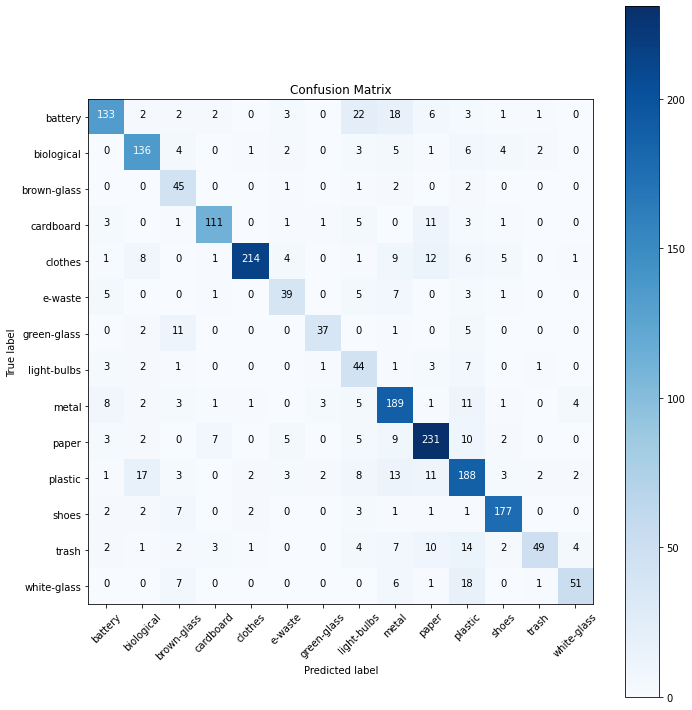

In [ ]:
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

# Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

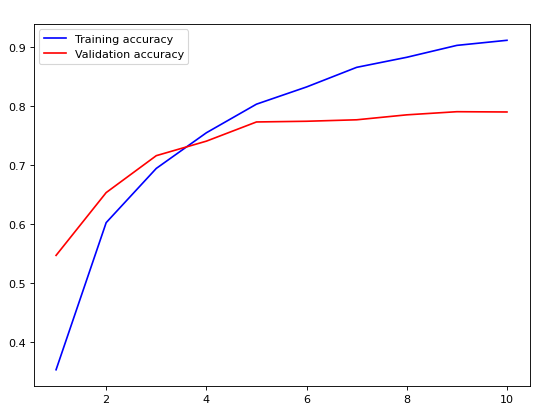

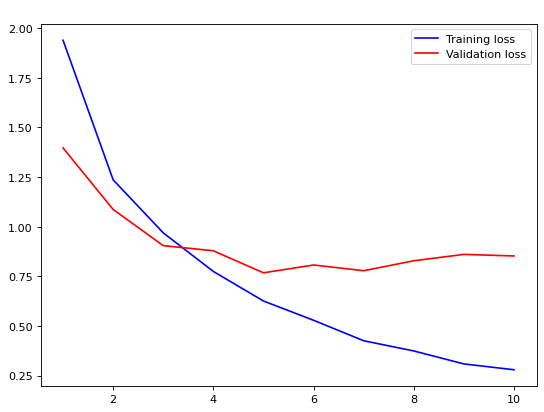

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(accuracy)+1)
plt.figure(figsize=(8,6),dpi=80)
plt.plot(epochs, accuracy, 'b', label = 'Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label = 'Validation accuracy')
plt.title('Training and validation accuracy ',color='w')
plt.legend()

plt.figure(figsize=(8,6),dpi=80)
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss ',color='w')
plt.legend()

plt.show()